In [2]:
import pandas as pd
from sklearn.datasets import load_wine

# Load dataset wine
wine = load_wine()

# Bikin DataFrame biar enak dibaca
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

lihat 5 data teratas
    alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline

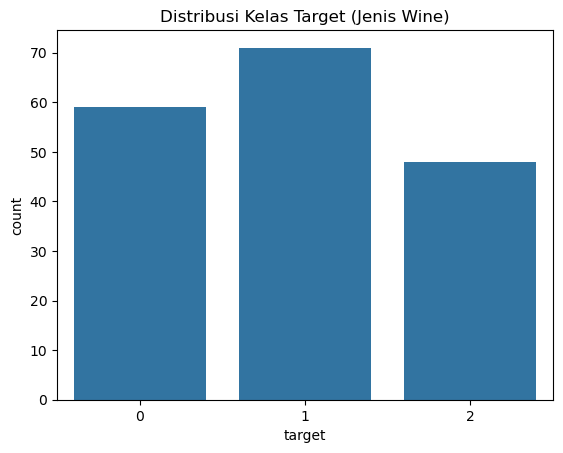

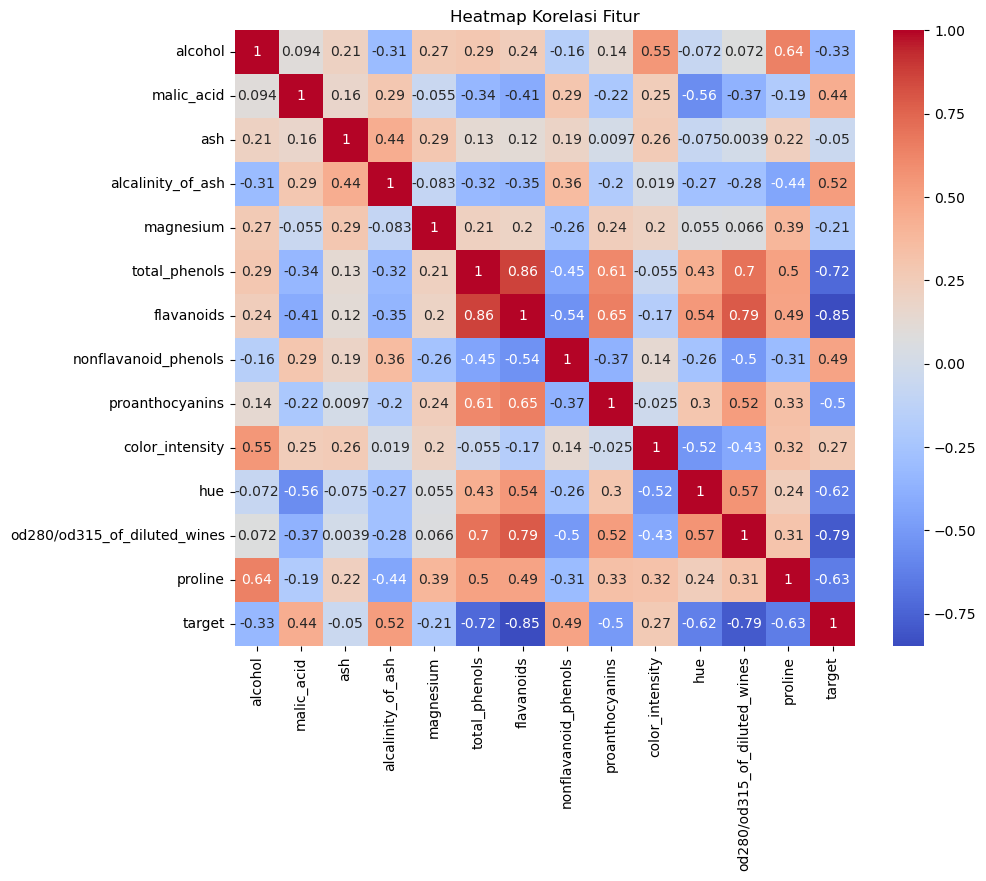

In [3]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Lihat 5 data teratas
print('lihat 5 data teratas\n',df.head(), '\n')

# Cek info dataset
print('Cek Missing Values\n', df.isnull().sum(), '\n')

# Cek distribusi target
sns.countplot(x='target', data=df)
plt.title('Distribusi Kelas Target (Jenis Wine)')
plt.show()

# Cek korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()

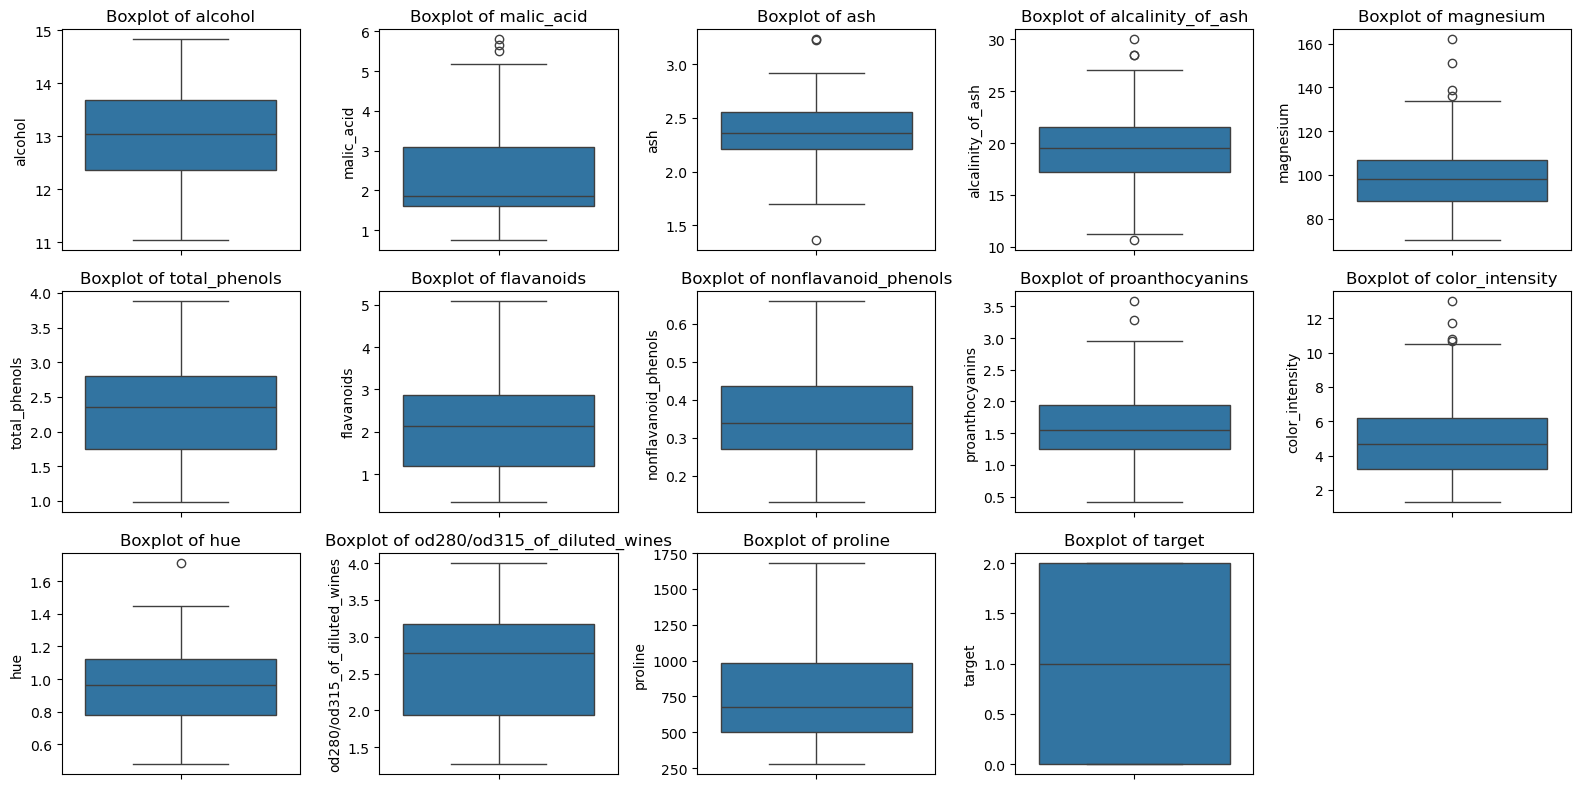

In [4]:
# Cek Outlier
import seaborn as sns 
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(16, 8))

# Create a boxplot for each feature in the dataframe
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


## Gak perlu Handle Outlier karna
### 1. Jumlah outlier sedikit di tiap fitur
### 2. Outlier-nya masih dalam batas wajar
### 3. Model machine learning modern tahan banting
### 4. Potensi informasi penting di dalam outlier

In [5]:
# Preprocessing
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
from sklearn.preprocessing import StandardScaler
scaled= StandardScaler()
X_train_scaled = scaled.fit_transform(X_train)
X_test_scaled = scaled.transform(X_test)

In [6]:
# Training Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting model
rf.fit(X_train_scaled, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test_scaled)

# Evaluasi Model
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nAccuracy Score:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Accuracy Score: 1.0

Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]


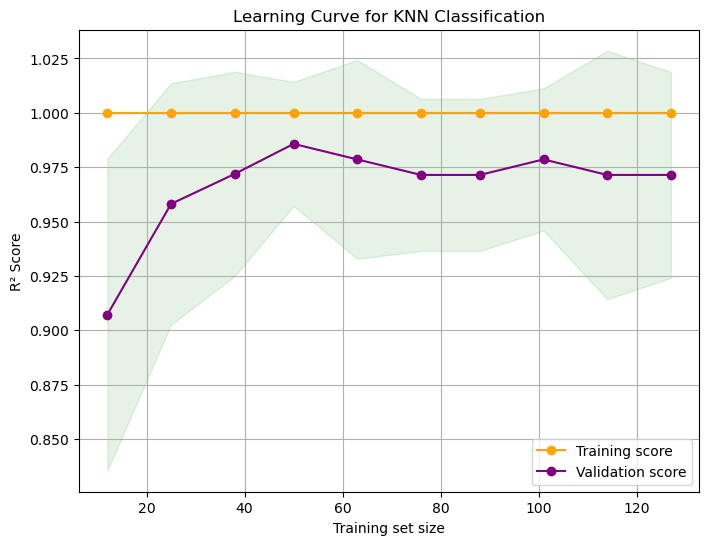

In [7]:
# learning curve for Training Model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Hitung rata-rata dan standar deviasi
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='orange', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='purple', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.xlabel('Training set size')
plt.ylabel('R² Score')
plt.title('Learning Curve for KNN Classification')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Because of Overfitting so we continue to the hyperparameter tuning (GridSearchCV)


Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 80}
Best cross-validation score: 0.9717 



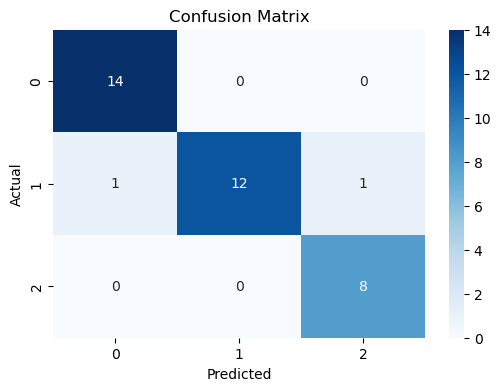

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 40, 50, 80],
    'min_samples_split': [5, 10,15],
    'min_samples_leaf': [4, 8 , 10, 20],
   'max_features': ['sqrt', 'log2', None],
}

# Model
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Hasil
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f} \n")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_rf_random = random_search.best_estimator_

# Prediksi di test set
y_pred = best_rf_random.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



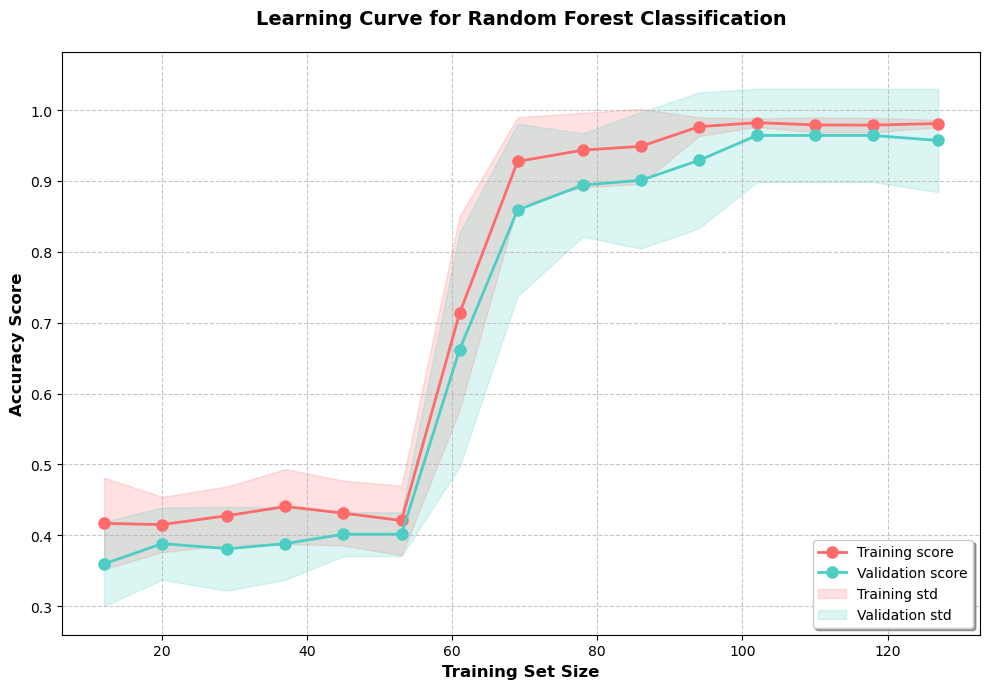

In [26]:
# Learning curve for RandomSearchCV with improved visualization

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns

# Calculate learning curve with more points for smoother curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_random, 
    X_train_scaled, 
    y_train, 
    cv=10, 
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 15),  # Increased number of points
    shuffle=True,  # Add shuffling for better randomization
    random_state=42  # For reproducibility
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create figure with improved styling
plt.figure(figsize=(10, 7))

# Plot curves with enhanced styling
plt.plot(train_sizes, train_mean, 'o-', color='#FF6B6B', label='Training score', linewidth=2, markersize=8)
plt.plot(train_sizes, test_mean, 'o-', color='#4ECDC4', label='Validation score', linewidth=2, markersize=8)

# Add confidence intervals with improved transparency
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='#FF6B6B', label='Training std')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                 alpha=0.2, color='#4ECDC4', label='Validation std')

# Enhance plot aesthetics
plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy Score', fontsize=12, fontweight='bold')  # Changed from R² to Accuracy
plt.title('Learning Curve for Random Forest Classification', fontsize=14, fontweight='bold', pad=20)

# Improve legend
plt.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)

# Add grid with better styling
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits slightly larger than the data range
plt.ylim(min(train_mean.min(), test_mean.min()) - 0.1,
         max(train_mean.max(), test_mean.max()) + 0.1)

# Tight layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()
